# Presentación

## Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

## Setup

### Instalar dependencias

In [15]:
pip install -r ../requirements.txt

     ---------------------------------------- 8.3/8.3 MB 11.2 MB/s eta 0:00:00
     --------------------------------------- 42.2/42.2 MB 10.9 MB/s eta 0:00:00
     ------------------------------------- 298.0/298.0 kB 18.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Cargar bibliotecas

In [16]:
#Manipulacion de datos y funciones matemáticas
import pandas as pd
import numpy as np

#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Modelo Lineal
from sklearn.linear_model import LinearRegression

#Metricas para evaluar modelos
from sklearn import metrics

### Cargar Dataset

In [2]:
hoteles_ds = pd.read_csv('../datasets/hotels_train.csv')

## Checkpoint 1

### Exploración inicial de datos

In [3]:
hoteles_ds.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.0,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.0,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.0,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0


In [4]:
hoteles_ds.shape

(61913, 33)

In [16]:
variables_enteras = hoteles_ds.select_dtypes(include=['int64']).columns
variables_flotantes = hoteles_ds.select_dtypes(include=['float64']).columns

variables_cualitativas = hoteles_ds.select_dtypes(include=['object']).columns

print("Variables cuantitativas: \n\tEnteros: ", variables_enteras, "\n\tFlotantes: ", variables_flotantes)
print("Variables cualitativas: ", variables_cualitativas)

Variables cuantitativas: 
	Enteros:  Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'babies', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'is_canceled'],
      dtype='object') 
	Flotantes:  Index(['children', 'agent', 'company', 'adr'], dtype='object')
Variables cualitativas:  Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date', 'id'],
      dtype='object')


### Visualización de los datos

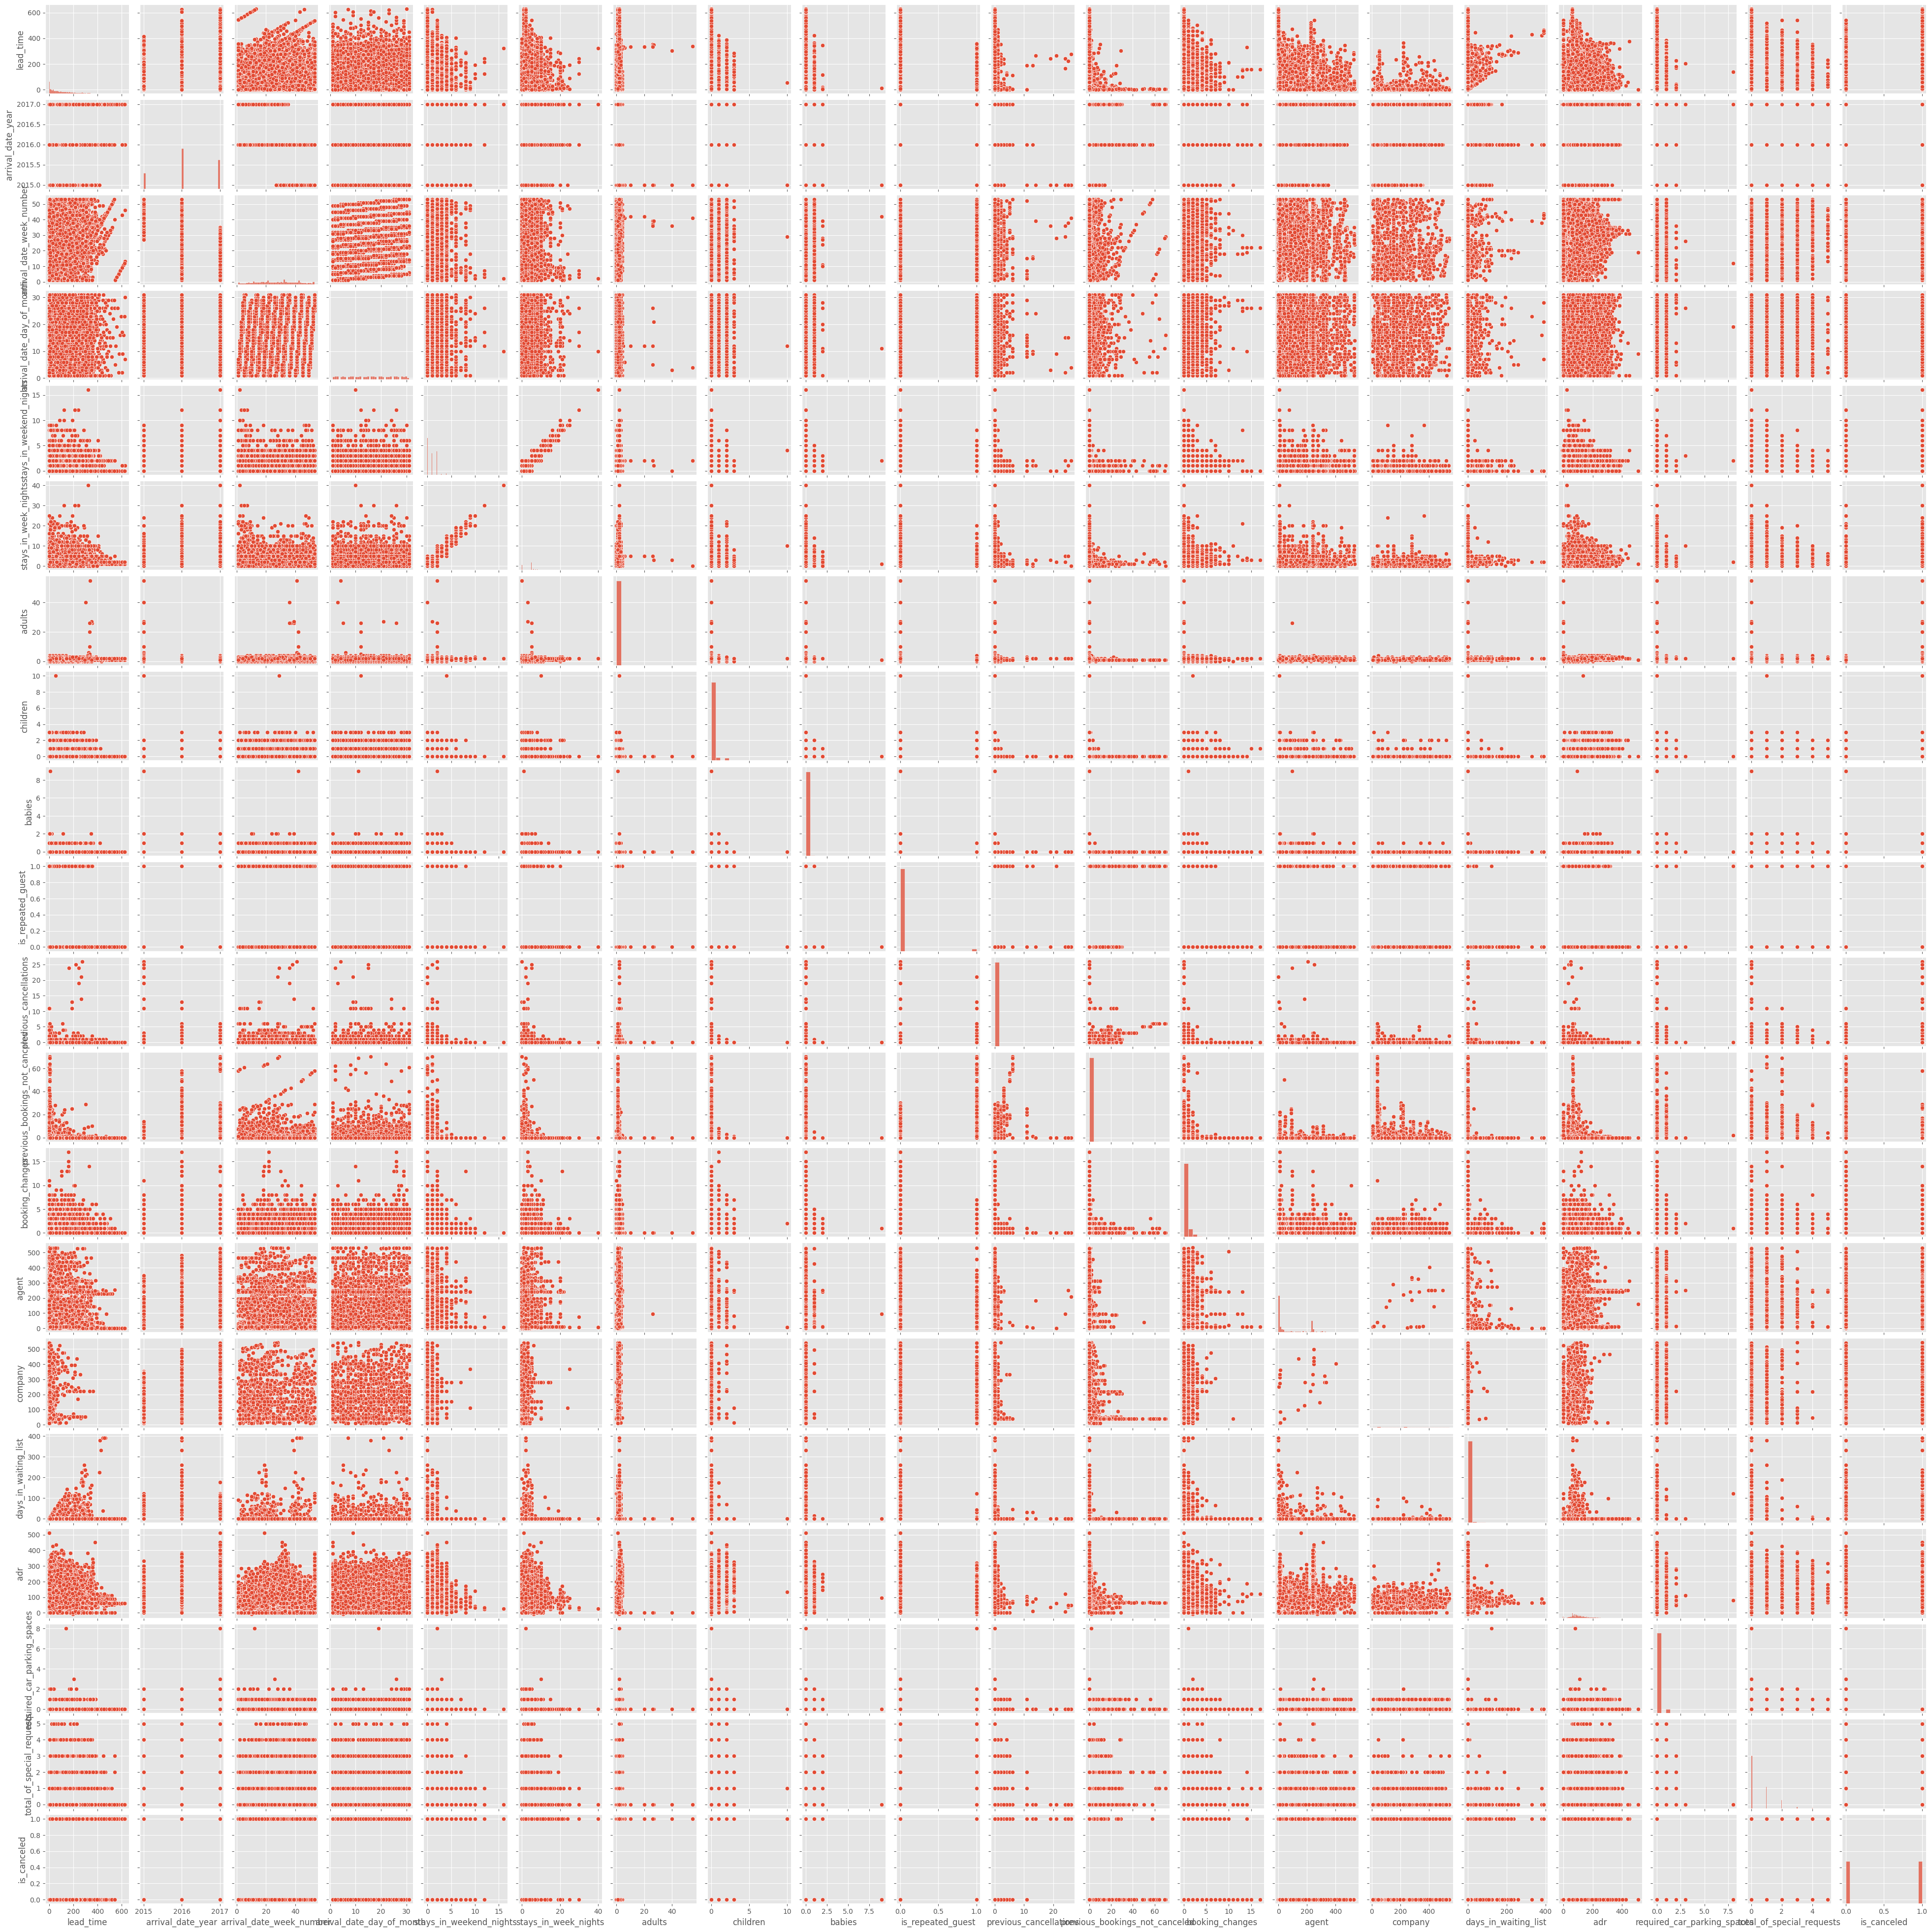

In [5]:
sns.pairplot(hoteles_ds, height=2)

### Datos Faltantes

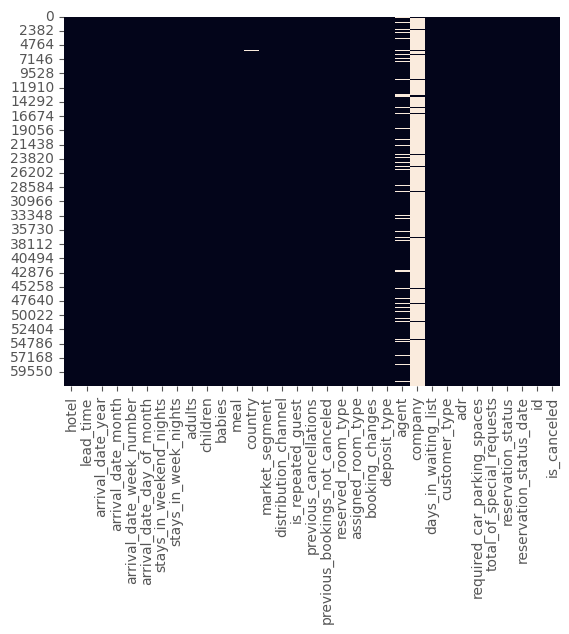

In [6]:
sns.heatmap(hoteles_ds.isnull(), cbar=False)
plt.show()

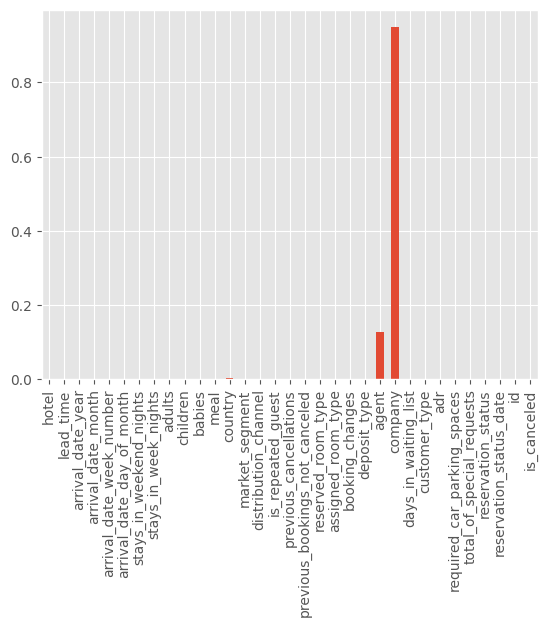

In [7]:
hoteles_ds.isnull().mean().plot(kind='bar')
plt.show()